In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
#tqdm for the progress bar
from tqdm import tqdm
print("All modules imported successfully.")

All modules imported successfully.


All of the files can be found on Kaggle.

https://www.kaggle.com/c/digit-recognizer/data

In [2]:
#load in data from kaggle
train_amt=37000

train_X=pd.read_csv("~/Downloads/train.csv")
#randomly shuffle it before splitting it into training and validation sets
#np.random.shuffle(train_X)

validation_X=train_X.loc[train_amt:]
train_X=train_X.loc[:train_amt-1]
train_y=train_X['label']
validation_y=validation_X['label']
del train_X['label']
del validation_X['label']
test_X=pd.read_csv("~/Downloads/test.csv")

In [3]:
#convert to numpy arrays and normalize values between 0 and 1
#normalizing allows the network to train better and converge faster
train_X=np.array(train_X)/255
train_y=np.array(train_y)
validation_X=np.array(validation_X)/255
validation_y=np.array(validation_y)
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape)
#test data
test_X=np.array(test_X).astype(dtype='float32')/255

(37000, 784) (37000,) (5000, 784) (5000,) (28000, 784)


In [4]:
train_X=train_X.reshape([-1, 28, 28, 1])
validation_X=validation_X.reshape([-1, 28, 28, 1])
test_X=test_X.reshape([-1, 28, 28, 1])
print(train_X.shape, validation_X.shape, test_X.shape)

(37000, 28, 28, 1) (5000, 28, 28, 1) (28000, 28, 28, 1)


In [5]:
#convert to one-hot array
train_y=np.array(pd.get_dummies(train_y))
validation_y=np.array(pd.get_dummies(validation_y))
print(train_y.shape, validation_y.shape)

(37000, 10) (5000, 10)


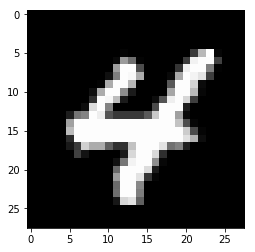

In [6]:
#show random number
test_img=train_X[np.random.randint(0,train_amt-1)].reshape(28,28)

plt.imshow(test_img, cmap='gray')
plt.show()

In [7]:
#make sure everything is a float32
tf.cast(train_X, tf.float32)
tf.cast(train_y, tf.float32)
tf.cast(validation_X, tf.float32)
tf.cast(validation_y, tf.float32)

<tf.Tensor 'Cast_3:0' shape=(5000, 10) dtype=float32>

In [8]:
#conv format=height, width, filters
#max pool format=side length
conv_layer1=[3,3,32]
conv_layer2=[3,3,64]
max_pool1=2
conv_layer3=[3,3,128]
conv_layer4=[3,3,256]
max_pool2=2
#output=7x7
nodes_fc1=1000
nodes_fc2=500
nodes_output=10

batch_size=128
num_epochs=25

In [9]:
regularizer=tf.contrib.layers.l2_regularizer(scale=0.002)

weights_conv_layer1=tf.get_variable('conv_weights_layer_1', dtype=tf.float32, 
                            initializer=tf.truncated_normal([conv_layer1[0], conv_layer1[1], 1, conv_layer1[2]], dtype=tf.float32, stddev=0.2),
                                   regularizer=regularizer)
biases_conv_layer1=tf.get_variable('conv_biases_layer_1', dtype=tf.float32, initializer= tf.zeros([conv_layer1[2]]))

weights_conv_layer2=tf.get_variable('conv_weights_layer_2', dtype=tf.float32, 
                            initializer=tf.truncated_normal([conv_layer2[0], conv_layer2[1], conv_layer1[2], conv_layer2[2]], dtype=tf.float32, stddev=0.2),
                                   regularizer=regularizer)

biases_conv_layer2=tf.get_variable('conv_biases_layer_2', dtype=tf.float32, initializer= tf.zeros([conv_layer2[2]]))

weights_conv_layer3=tf.get_variable('conv_weights_layer_3', dtype=tf.float32, 
                            initializer=tf.truncated_normal([conv_layer3[0], conv_layer3[1], conv_layer2[2], conv_layer3[2]], dtype=tf.float32, stddev=0.2),
                                   regularizer=regularizer)
biases_conv_layer3=tf.get_variable('conv_biases_layer_3', dtype=tf.float32, initializer= tf.zeros([conv_layer3[2]]))

weights_conv_layer4=tf.get_variable('conv_weights_layer_4', dtype=tf.float32, 
                            initializer=tf.truncated_normal([conv_layer4[0], conv_layer4[1], conv_layer3[2], conv_layer4[2]], dtype=tf.float32, stddev=0.2),
                                   regularizer=regularizer)
biases_conv_layer4=tf.get_variable('conv_biases_layer_4', dtype=tf.float32, initializer= tf.zeros([conv_layer4[2]]))

weights_fc1=tf.get_variable('weights_fc1', dtype=tf.float32, 
                            initializer=tf.truncated_normal([49*conv_layer4[2], nodes_fc1], dtype=tf.float32, stddev=np.sqrt(2/nodes_fc1)),
                           regularizer=regularizer)
biases_fc1=tf.get_variable('biases_fc1', dtype=tf.float32, initializer=tf.zeros([nodes_fc1]))

weights_fc2=tf.get_variable('weights_fc2', dtype=tf.float32, 
                            initializer=tf.truncated_normal([nodes_fc1, nodes_fc2], dtype=tf.float32, stddev=np.sqrt(2/nodes_fc2)),
                           regularizer=regularizer)
biases_fc2=tf.get_variable('biases_fc2', dtype=tf.float32, initializer=tf.zeros([nodes_fc2]))

weights_output=tf.get_variable('weights_output', dtype=tf.float32, 
                               initializer=tf.truncated_normal([nodes_fc2, nodes_output], dtype=tf.float32, stddev=np.sqrt(2/nodes_output)),
                              regularizer=regularizer)

In [10]:
def conv_layer(layer_input, layer_weights, layer_biases, is_training, strides=1):
    conv_layer=tf.nn.conv2d(layer_input, layer_weights, [1, strides, strides, 1], 'SAME')
    conv_layer=tf.nn.bias_add(conv_layer, layer_biases)
    #batch normalization
    conv_layer = tf.layers.batch_normalization(conv_layer, training = is_training)
    conv_layer=tf.nn.elu(conv_layer)
    return conv_layer

In [11]:
def max_pool(layer, width):
    return tf.nn.max_pool(value=layer, ksize=[1, width, width, 1], strides=[1, width, width, 1], padding='VALID')

In [12]:
#setting up placeholders where data will be passed into  later
features=tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
labels=tf.placeholder(tf.float32)
train=tf.placeholder(tf.bool)

In [13]:
#create saver, max_to_keep is maximum checkpoint files kept
saver=tf.train.Saver(max_to_keep=1)

In [14]:
def forward_pass(x, train):
    #train is a bool
    #set conv keep to a number if train is true, else set it to 1
    conv_keep=0.8 if train is not None else 1.0
    fc_keep=0.7 if train is not None else 1.0
    
    conv_layer1=conv_layer(x, weights_conv_layer1, biases_conv_layer1, train)
    conv_layer1=tf.nn.dropout(conv_layer1, conv_keep)
    
    conv_layer2=conv_layer(conv_layer1, weights_conv_layer2, biases_conv_layer2, train)
    conv_layer2=tf.nn.dropout(conv_layer2, conv_keep)
    
    max_pool_1=max_pool(conv_layer2, max_pool1)
    
    conv_layer3=conv_layer(max_pool_1, weights_conv_layer3, biases_conv_layer3, train)
    conv_layer3=tf.nn.dropout(conv_layer3, conv_keep)
    
    conv_layer4=conv_layer(conv_layer3, weights_conv_layer4, biases_conv_layer4, train)
    conv_layer4=tf.nn.dropout(conv_layer4, conv_keep)
    
    max_pool_2=max_pool(conv_layer4, max_pool2)
    
    fc_input=tf.contrib.layers.flatten(max_pool_2)
    
    fc1=tf.add(tf.matmul(fc_input, weights_fc1), biases_fc1)
    #batch norm
    fc1=tf.layers.batch_normalization(fc1, training = train)
    fc1=tf.nn.dropout(fc1, fc_keep)
    fc1=tf.nn.elu(fc1)
    
    fc2=tf.add(tf.matmul(fc1, weights_fc2), biases_fc2)
    fc2=tf.layers.batch_normalization(fc2, training = train)
    fc2=tf.nn.dropout(fc2, fc_keep)
    fc2=tf.nn.elu(fc2)
    
    logits=tf.matmul(fc2, weights_output)
    return logits

In [15]:
#cost and gradient descent
#tf.reduce_mean=np.mean and tf.reduce_sum=np.sum
lr=1e-2
learning_rate=tf.placeholder(tf.float32, shape=[])

logits=forward_pass(features,train)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#accuracy
#argmax takes the maximum value in each vector and sets it to 1, all others are set to 0
output=tf.nn.softmax(logits)
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(output, 1), tf.argmax(labels, 1)),tf.float32))

#used later for predicting the test data
prediction=tf.argmax(tf.nn.softmax(logits=output), 1)

In [16]:
import time
before_time=time.time()

with tf.Session() as sess:
    #initialize variables
    sess.run(tf.global_variables_initializer())
    #restore weights if file found
    try:
        saver.restore(sess, "/tmp/model.ckpt")
        print("Model restored.")
    except:
        print("No save file found.")

    
    batch_count = int(math.ceil(len(train_X)/batch_size))
    val_batches= int(math.ceil(len(validation_X)/1000))
    best_val_acc=0
    last_improve_epoch=0
    for epoch in range(num_epochs):
        #shuffle data
        state=np.random.get_state()
        np.random.shuffle(train_X)
        np.random.set_state(state)
        np.random.shuffle(train_y)
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch+1, num_epochs), unit='batches')
        train_loss=0.0
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_X[batch_start:batch_start + batch_size]
            batch_labels = train_y[batch_start:batch_start + batch_size]
            #train
            _, c = sess.run([optimizer, cost], feed_dict={features: batch_features, labels: batch_labels, 
                                                          learning_rate: lr, train: True})
            train_loss+=c
        #set keep amount to 100% for testing
        validation_accuracy=0
        for batch_i in range(val_batches):
            batch_start = batch_i*batch_size
            validation_accuracy+=sess.run(accuracy, 
                                          feed_dict={features: validation_X[batch_start:batch_start+batch_size],
                                                     labels: validation_y[batch_start:batch_start+batch_size],
                                                     train: False})
        validation_accuracy/=val_batches
        print('Training Loss = {}, Validation Accuracy = {}'.format(train_loss, validation_accuracy))

        #save model if validation is at a new best
        if validation_accuracy>best_val_acc:
            save_path = saver.save(sess, "/tmp/model.ckpt")
            print("Model saved in file: {}".format(save_path))
            print("Accuracy improved from {} to {}".format(best_val_acc, validation_accuracy))
            best_val_acc=validation_accuracy
            last_improve_epoch=epoch
        #if model hasn't improved for 5 epochs step down learning rate
        elif (epoch-last_improve_epoch)%5==0:
            lr=max(lr/2,1e-6)
            print("Learning rate decreased to {}.".format(lr))
        #stop training if validation loss hasn't improved for 10 epoch
        
    print("Training Finished! It took {} minutes.\n Best validation accuracy: {}"
          .format(np.round((time.time()-before_time)/60,2), best_val_acc))
    
    #load in best model
    try:
        saver.restore(sess, "/tmp/model.ckpt")
        print("Best Model restored.")
    except:
        print("No save file found. Prediction will use current weights which may not be the best.")
       
        
    predictions=np.array([])
    batches_test = int(math.ceil(len(test_X)/batch_size))
    progress_bar = tqdm(range(batches_test), desc='Generating Predictions', unit='batches')
    for batch_i in progress_bar:
        # Get a batch of test features and labels
        batch_start = batch_i*batch_size
        batch_features = test_X[batch_start:batch_start + batch_size]
        predictions=np.append(predictions, sess.run(prediction, feed_dict={features: batch_features, train: False}))
    print(predictions.shape)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored.


Epoch  1/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:35<00:00,  8.26batches/s]


Training Loss = 94.68707298691152, Validation Accuracy = 0.9453125
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0 to 0.9453125


Epoch  2/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.69batches/s]


Training Loss = 36.30836476298282, Validation Accuracy = 0.9796875
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9453125 to 0.9796875


Epoch  3/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.63batches/s]


Training Loss = 18.143628604258993, Validation Accuracy = 0.9890625
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9796875 to 0.9890625


Epoch  4/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.76batches/s]


Training Loss = 14.72338069230318, Validation Accuracy = 0.9703125


Epoch  5/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.74batches/s]


Training Loss = 12.649944556178525, Validation Accuracy = 0.98125


Epoch  6/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.66batches/s]


Training Loss = 11.4087734515997, Validation Accuracy = 0.9828125


Epoch  7/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.75batches/s]


Training Loss = 10.221424190196558, Validation Accuracy = 0.9734375


Epoch  8/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.74batches/s]


Training Loss = 15.922715500684717, Validation Accuracy = 0.9859375
Learning rate decreased to 0.005.


Epoch  9/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.75batches/s]


Training Loss = 5.807273441518191, Validation Accuracy = 0.990625
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.9890625 to 0.990625


Epoch 10/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.75batches/s]


Training Loss = 6.158489199195174, Validation Accuracy = 0.9875


Epoch 11/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.68batches/s]


Training Loss = 6.150204072444467, Validation Accuracy = 0.9859375


Epoch 12/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.78batches/s]


Training Loss = 3.9284187627927167, Validation Accuracy = 0.9859375


Epoch 13/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.78batches/s]


Training Loss = 6.640222938258374, Validation Accuracy = 0.9890625


Epoch 14/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.71batches/s]


Training Loss = 3.296627636944322, Validation Accuracy = 0.9828125
Learning rate decreased to 0.0025.


Epoch 15/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.75batches/s]


Training Loss = 2.1831471326513565, Validation Accuracy = 0.990625


Epoch 16/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.75batches/s]


Training Loss = 2.526394499186722, Validation Accuracy = 0.9875


Epoch 17/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.76batches/s]


Training Loss = 1.7379512047955359, Validation Accuracy = 0.9875


Epoch 18/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.75batches/s]


Training Loss = 2.6533792337722844, Validation Accuracy = 0.990625


Epoch 19/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.75batches/s]


Training Loss = 1.9781479279536143, Validation Accuracy = 0.990625
Learning rate decreased to 0.00125.


Epoch 20/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:32<00:00,  8.79batches/s]


Training Loss = 1.2166584597028418, Validation Accuracy = 0.9890625


Epoch 21/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:32<00:00,  8.82batches/s]


Training Loss = 1.3730863210075768, Validation Accuracy = 0.9859375


Epoch 22/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.76batches/s]


Training Loss = 1.303329743620992, Validation Accuracy = 0.9859375


Epoch 23/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.78batches/s]


Training Loss = 0.9596357564969367, Validation Accuracy = 0.990625


Epoch 24/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:33<00:00,  8.78batches/s]


Training Loss = 0.6149614761234261, Validation Accuracy = 0.990625
Learning rate decreased to 0.000625.


Epoch 25/25: 100%|██████████████████████████████████████████████████████████████| 290/290 [00:32<00:00,  8.79batches/s]


Training Loss = 0.5749583488886856, Validation Accuracy = 0.9921875
Model saved in file: /tmp/model.ckpt
Accuracy improved from 0.990625 to 0.9921875
Training Finished! It took 15.0 minutes.
 Best validation accuracy: 0.9921875
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Best Model restored.


Generating Predictions: 100%|███████████████████████████████████████████████████| 219/219 [00:09<00:00, 23.63batches/s]


(28000,)


In [17]:
#use replace the 0s in the sample submission file with the outputs from the neural net
submission=pd.read_csv("~/Downloads/sample_submission.csv")
for x in range(len(predictions)):
    submission['Label'][x]+=predictions[x]

In [18]:
print(submission)

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
5            6      7
6            7      0
7            8      3
8            9      0
9           10      3
10          11      5
11          12      7
12          13      4
13          14      0
14          15      4
15          16      3
16          17      3
17          18      1
18          19      9
19          20      0
20          21      9
21          22      1
22          23      1
23          24      5
24          25      7
25          26      4
26          27      2
27          28      7
28          29      4
29          30      7
...        ...    ...
27970    27971      5
27971    27972      0
27972    27973      4
27973    27974      8
27974    27975      0
27975    27976      3
27976    27977      6
27977    27978      0
27978    27979      1
27979    27980      9
27980    27981      3
27981    27982      1
27982    27983      1
27983    2

In [19]:
#index=False gets rid of the double numbers
submission.to_csv("~/Downloads/submission.csv", index=False)